# Predictions using XGBoost on Tabular Data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from src.data.prepare_data import format_tabular
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import RandomizedSearchCV
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from random import sample

In [3]:
SEED = 2718

In [4]:
train_internal = pd.read_csv('../data/internal/train.csv')
train_external = pd.read_csv('../data/external/train.csv')
test_raw = pd.read_csv('../data/internal/test.csv')

In [5]:
train_internal.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [6]:
test_raw.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


First we train using internal data. We will try random over sampling of the minority class (malignant) and synthetic minority over-sampling (SMOTE).

In [7]:
X_train, X_test, y_train = format_tabular(train_internal, test_raw, count=False)

In [8]:
X_train.isna().sum()

sex                0
age_approx         0
width              0
height             0
NA                 0
head/neck          0
lower extremity    0
oral/genital       0
palms/soles        0
torso              0
upper extremity    0
dtype: int64

In [9]:
X_train.head()

,sex,age_approx,width,height,NA,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,1.0,45.0,6000,4000,0,1,0,0,0,0,0
1,0.0,45.0,6000,4000,0,0,0,0,0,0,1
2,0.0,50.0,1872,1053,0,0,1,0,0,0,0
3,0.0,45.0,1872,1053,0,1,0,0,0,0,0
4,0.0,55.0,6000,4000,0,0,0,0,0,0,1


In [10]:
X_test.head()

,sex,age_approx,width,height,NA,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,1.0,70.0,6000,4000,1,0,0,0,0,0,0
1,1.0,40.0,6000,4000,0,0,1,0,0,0,0
2,0.0,55.0,6000,4000,0,0,0,0,0,1,0
3,0.0,50.0,6000,4000,0,0,0,0,0,1,0
4,0.0,45.0,1920,1080,0,0,1,0,0,0,0


In [11]:
model_randoversamp = Pipeline([
    ('sampler', RandomOverSampler(random_state=SEED)),
    ('classification', XGBClassifier(verbosity=1, random_state=SEED))
])

In [12]:
params_randoversamp = {
    'sampler__sampling_strategy': [0.1, 0.3, 0.5],
    'classification__eta': [0.0001, 0.001, 0.01, 0.1, 1],
    'classification__gamma': [0, 1, 2, 3, 4, 5],
    'classification__max_depth': [x for x in range(1, 11)],
    'classification__num_estimators': [100, 300, 500, 700, 900]
}

In [13]:
cv_iterator_int = []
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (idxT,idxV) in enumerate(skf.split(np.arange(15))):
    cv_iterator_int.append((train_internal.tfrecord.isin(idxT), 
                        train_internal.tfrecord.isin(idxV)))

In [14]:
grid_randoversamp = RandomizedSearchCV(estimator=model_randoversamp, 
                          param_distributions=params_randoversamp, 
                          n_iter=100, 
                          scoring='roc_auc', 
                          cv=cv_iterator_int, 
                          verbose=1, 
                          n_jobs=-1)

In [15]:
grid_randoversamp.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.6min finished


[12:25:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
33121    True
33122    True
33123    True
33124    True
33125    True
Name: tfrecord, Length: 33126, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: tfrecord, Length: 33126, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
33121     True
33122     True
33123     True
33124     True
33125     True
Name: tfrecord, Leng...
                                                            tree_method=None,
                                                            validate_parameters=None,
                                                            verbosity=1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classif

In [16]:
grid_randoversamp.best_estimator_

Pipeline(steps=[('sampler',
                 RandomOverSampler(random_state=2718, sampling_strategy=0.5)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_estimators=700,
                               num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                       

In [17]:
grid_randoversamp.best_score_

0.8297698703556824

In [18]:
submission = pd.read_csv('../data/internal/sample_submission.csv')

In [19]:
preds_randoversamp = grid_randoversamp.predict_proba(X_test)
preds_randoversamp[:, 1]

array([0.06370132, 0.03028808, 0.04292613, ..., 0.34648108, 0.07405457,
       0.29158518], dtype=float32)

In [20]:
submission['target'] = preds_randoversamp[:, 1]

In [21]:
submission.to_csv('../submissions/xgboost_internal_randomoversampling.csv', index=False)

In [22]:
filename = "../models/xgboost_internal_randomoversampling.pkl"
with open(filename, 'wb') as file:
    pickle.dump(grid_randoversamp, file)

This submission achieved a score of 0.7981

In [23]:
model_smote = Pipeline([
    ('sampler', SMOTE(random_state=SEED, n_jobs=-1)),
    ('classification', XGBClassifier(verbosity=1, random_state=SEED))
])

In [24]:
params_smote = {
    'sampler__k_neighbors': [1, 3, 5, 7],
    'classification__eta': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'classification__gamma': [0, 1, 2, 3, 4, 5],
    'classification__max_depth': [1, 2, 3, 4, 5, 6],
    'classification__num_estimators': [100, 300, 500, 700, 900]    
}

In [25]:
grid_smote = RandomizedSearchCV(estimator=model_smote, 
                                param_distributions=params_smote, 
                                n_iter=100, 
                                scoring='roc_auc', 
                                cv=cv_iterator_int, 
                                verbose=1, 
                                n_jobs=-1)

In [26]:
grid_smote.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.5min finished


[12:34:56] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
33121    True
33122    True
33123    True
33124    True
33125    True
Name: tfrecord, Length: 33126, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: tfrecord, Length: 33126, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
33121     True
33122     True
33123     True
33124     True
33125     True
Name: tfrecord, Leng...
                                                            subsample=None,
                                                            tree_method=None,
                                                            validate_parameters=None,
                                                            verbosity=1))]),
              

In [27]:
grid_smote.best_estimator_

Pipeline(steps=[('sampler', SMOTE(k_neighbors=1, n_jobs=-1, random_state=2718)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_estimators=500,
                               num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameter

In [28]:
grid_smote.best_score_

0.819154065329459

In [29]:
preds_smote = grid_smote.predict_proba(X_test)

In [30]:
submission = pd.read_csv('../data/internal/sample_submission.csv')
submission['target'] = preds_smote[:, 1]
submission.to_csv('../submissions/xgboost_internal_smote.csv', index=False)

This achieved a score of 0.7664 on the public leaderboard.

Now let's try adding external data with random over-sampling, as that performed better than the SMOTE sampling.

In [31]:
X_ext_train, y_ext_train = format_tabular(train_external)

The 2019 data provided three separate torso areas for the lesions. The 2020 data only contained a general torso category so the three must be combined to one to match the internal training data

In [32]:
X_ext_train['torso'] = X_ext_train['anterior torso'] + X_ext_train['posterior torso'] + X_ext_train['lateral torso']

In [33]:
X_ext_train.drop(['anterior torso', 'posterior torso', 'lateral torso'], axis=1, inplace=True)

In [34]:
X_train_all = pd.concat([X_train, X_ext_train], axis=0, ignore_index=True)
y_train_all = pd.concat([y_train, y_ext_train], axis=0, ignore_index=True)

In [35]:
tf_int = train_internal['tfrecord']
tf_ext = train_external['tfrecord']
tf_ext += 20
tf = pd.concat([tf_int, tf_ext], axis=0, ignore_index=True)

In [36]:
cv_iterator_ext = []
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (idxT,idxV) in enumerate(skf.split(np.arange(15))):
    cv_iterator_ext.append((tf.isin(idxT) | (tf >= 20), 
                        tf.isin(idxV)))

In [37]:
grid_randoversamp_ext = RandomizedSearchCV(estimator=model_randoversamp, 
                                       param_distributions=params_randoversamp, 
                                       n_iter=100, 
                                       scoring='roc_auc', 
                                       cv=cv_iterator_ext, 
                                       verbose=1, 
                                       n_jobs=-1)

In [38]:
grid_randoversamp_ext.fit(X=X_train_all, y=y_train_all)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.0min finished


[12:47:00] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
58452    True
58453    True
58454    True
58455    True
58456    True
Name: tfrecord, Length: 58457, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
58452    False
58453    False
58454    False
58455    False
58456    False
Name: tfrecord, Length: 58457, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
58452     True
58453     True
58454     True
58455     True
58456     True
Name: tfrecord, Leng...
                                                            tree_method=None,
                                                            validate_parameters=None,
                                                            verbosity=1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classif

In [39]:
grid_randoversamp_ext.best_estimator_

Pipeline(steps=[('sampler',
                 RandomOverSampler(random_state=2718, sampling_strategy=0.3)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=4, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_estimators=100,
                               num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                       

In [40]:
grid_randoversamp_ext.best_score_

0.8286901666421832

This score is almost exactly as using the internal data but we will still try submitting. This model scored 0.7959 on the public leaderboard so a small amount worse than just using the internal data. 

In [41]:
preds_randover_ext = grid_randoversamp_ext.predict_proba(X_test)
submission = pd.read_csv('../data/internal/sample_submission.csv')
submission['target'] = preds_randover_ext[:, 1]
submission.to_csv('../submissions/xgboost_external_randover.csv', index=False)

Finally, can we find any parameters for the classification which perform better by searching for longer using probability distributions for the parameters rather than lists?

In [42]:
params_randoversamp = {
    'sampler__sampling_strategy': stats.uniform(0.1, 0.5),
    'classification__eta': stats.gamma(a=2, scale=0.05),
    'classification__gamma': stats.gamma(a=2, scale=2),
    'classification__max_depth': stats.randint(low=1, high=3),
    'classification__n_estimators': stats.randint(low=50, high=150),
}

In [43]:
grid_randoversamp = RandomizedSearchCV(estimator=model_randoversamp, 
                                       param_distributions=params_randoversamp, 
                                       n_iter=200, scoring='roc_auc', 
                                       cv=cv_iterator_int, 
                                       verbose=1, 
                                       random_state=SEED, 
                                       n_jobs=-1)

In [44]:
grid_randoversamp.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.6min finished


RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
33121    True
33122    True
33123    True
33124    True
33125    True
Name: tfrecord, Length: 33126, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: tfrecord, Length: 33126, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
33121     True
33122     True
33123     True
33124     True
33125     True
Name: tfrecord, Leng...
                                        'classification__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f23e29b8280>,
                                        'classification__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f23e27fa4c0>,
                                        'classificati

In [45]:
grid_randoversamp.best_estimator_

Pipeline(steps=[('sampler',
                 RandomOverSampler(random_state=2718,
                                   sampling_strategy=0.41151534199277284)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.23951759613943807,
                               gamma=4.822908763236613, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.239517599, max_delta_step=0,
                               max_depth=1, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=142,
                               n_jobs=0, num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                         

In [46]:
grid_randoversamp.best_score_

0.8306332759120568

This is slightly better than before. Let's see how it does on the test set and save the model.

In [47]:
preds_randover = grid_randoversamp.predict_proba(X_test)
submission = pd.read_csv('../data/internal/sample_submission.csv')
submission['target'] = preds_randover[:, 1]
submission.to_csv('../submissions/xgboost_internal_randover_dist.csv', index=False)

This one scored 0.8166 so a good improvement by searching using more varied parameters.

In [48]:
filename = "../models/xgboost_internal_randomoversamplingdist.pkl"
with open(filename, 'wb') as file:
    pickle.dump(grid_randoversamp, file)

In [49]:
with open(filename, 'rb') as file:
    final_model = pickle.load(file)

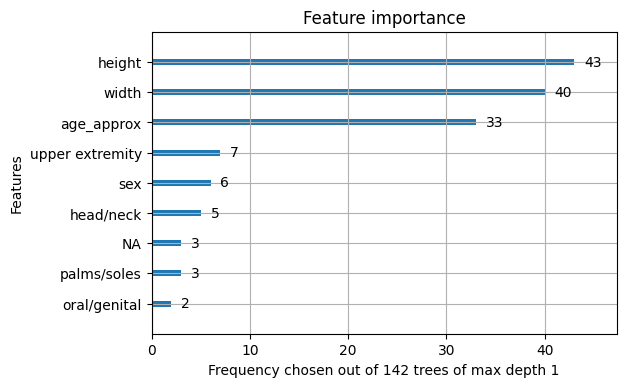

In [50]:
fig, ax = plt.subplots(dpi=100)
plot_importance(final_model.best_estimator_.named_steps["classification"], 
                ax=ax, 
                xlabel=f"Frequency chosen out of {final_model.best_params_['classification__n_estimators']} trees of max depth {final_model.best_params_['classification__max_depth']}")
fig.savefig('../images/feature_importance.png')

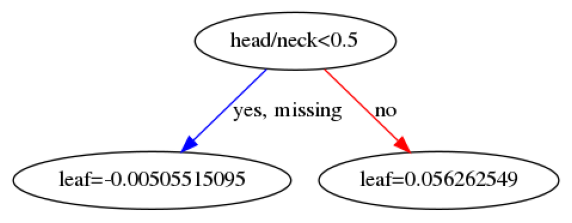

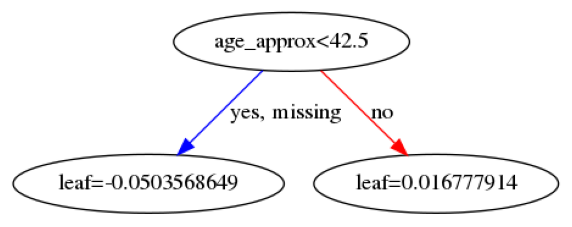

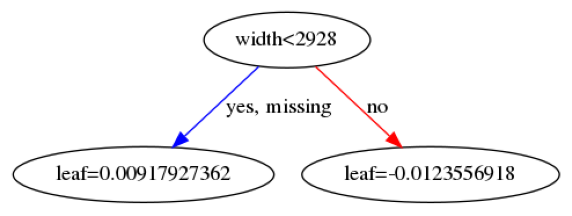

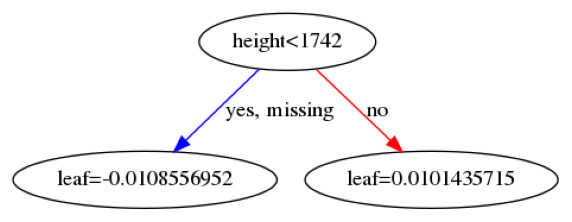

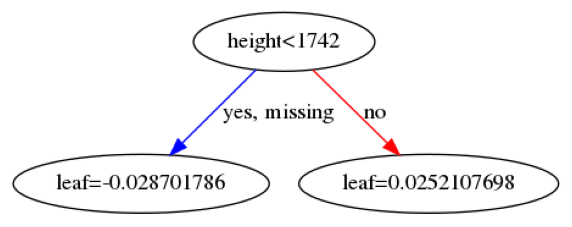

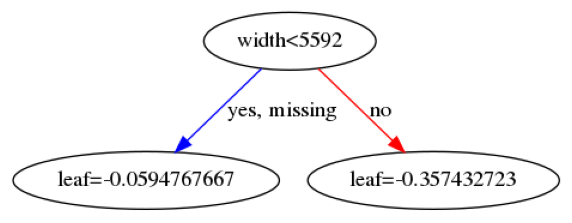

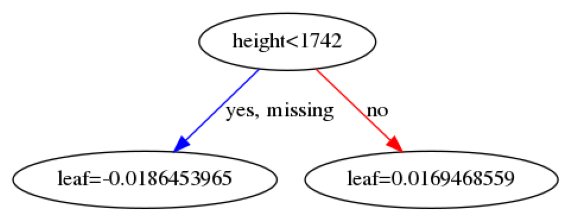

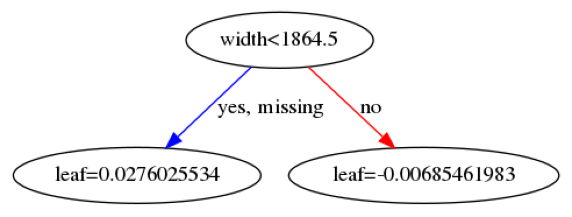

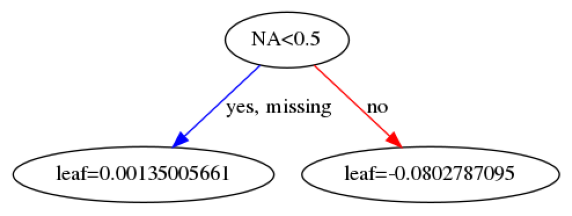

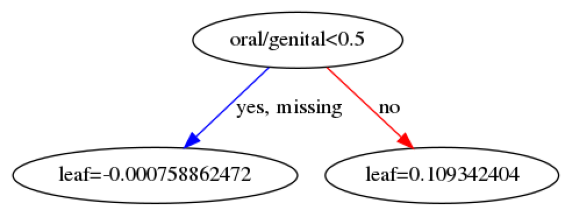

In [51]:
for i in sample(set(np.arange(final_model.best_params_['classification__n_estimators'])), 10):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_tree(final_model.best_estimator_.named_steps["classification"], num_trees=i, ax=ax)
    fig.savefig(f'../images/tree_{i}.png')